In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as gobj
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from collections import Counter
import statsmodels.api as sm
import scipy.stats.distributions as dist
from scipy.stats import t,ttest_rel
from statsmodels.stats.weightstats import ztest
from warnings import simplefilter
simplefilter("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import geopandas as gpd


# Load the datasets
train_data = pd.read_csv('train.csv')  # Replace with your train file path
test_data = pd.read_csv('test.csv')   # Replace with your test file path

# Splitting features and target in training data
X = train_data.drop(columns=["happiness", "ID"])
y = train_data["happiness"]


In [3]:
# Handling categorical columns and missing values
categorical_features = ["country"]
numerical_features = X.select_dtypes(include=["float64", "int64"]).columns.drop("year")


In [4]:
# Preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [5]:
# Splitting train data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)



In [6]:
# Random Forest Model
rf = RandomForestRegressor(random_state=42)


In [7]:
# Parameter grid for RandomizedSearchCV
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ['auto', 'sqrt', 'log2'],
    "bootstrap": [True, False],
}


In [8]:
# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=3, scoring='neg_mean_squared_error',
                                   verbose=2, random_state=42, n_jobs=-1)


In [9]:
# Creating a pipeline with preprocessing and random search
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("random_search", random_search),
])

In [10]:
# Training the model
model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['log_gdp_per_capita', 'social_support', 'life_expectancy',
       'freedom_choices', 'generosity', 'corruption', 'positive_affect',
       'negative_affect'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'...
                 RandomizedSearchCV(cv=3,
                                    estimator=RandomForestRegressor(random_state=42),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'bootstrap': [True,
                                                                       False],
                                                         'max_depth': [None, 10,
                                                                       20, 30,
                                                                       40],
                                                         'max_features': ['auto',
                                                                          'sqrt',
                                                                          'log2'],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              4,
                                                                              8],
                                                         'min_samples_split': [2,
                                                                               5,
                                                                               10,
                                                                               20],
                                                         'n_estimators': [100,
                                                                          200,
                                                                          300,
                                                                          500]},
                                    random_state=42,
                                    scoring='neg_mean_squared_error',
                                    verbose=2))])

In [11]:
# Best model and its parameters
best_model = model.named_steps["random_search"].best_estimator_
print("Best Parameters:", model.named_steps["random_search"].best_params_)

# Validate the best model
y_pred = best_model.predict(model.named_steps['preprocessor'].transform(X_valid))
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(f"Validation RMSE: {rmse}")


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': False}
Validation RMSE: 0.3783085343874213


In [12]:
# Predicting happiness scores for the test set
test_features = test_data.drop(columns=["ID"])
test_ids = test_data["ID"]


In [13]:
# Applying the preprocessing steps on the test data
test_features_processed = model.named_steps['preprocessor'].transform(test_features)


In [14]:
# Predicting happiness scores
test_predictions = best_model.predict(test_features_processed)


In [15]:
# Creating the output DataFrame
output = pd.DataFrame({
    "ID": test_ids,
    "happiness": test_predictions
})

# Saving the output to a CSV file
output.to_csv('happiness_predictions.csv', index=False)  # Replace with your desired output path

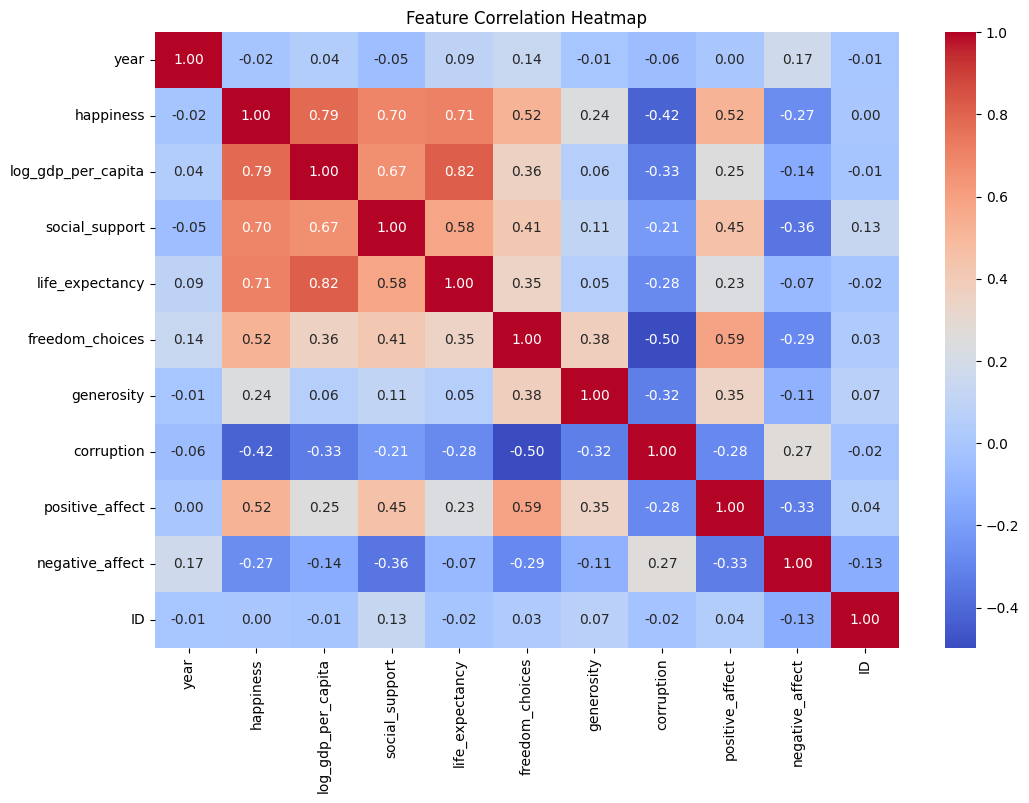

In [16]:
# Load dataset
train_data = pd.read_csv('train.csv')

# Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = train_data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

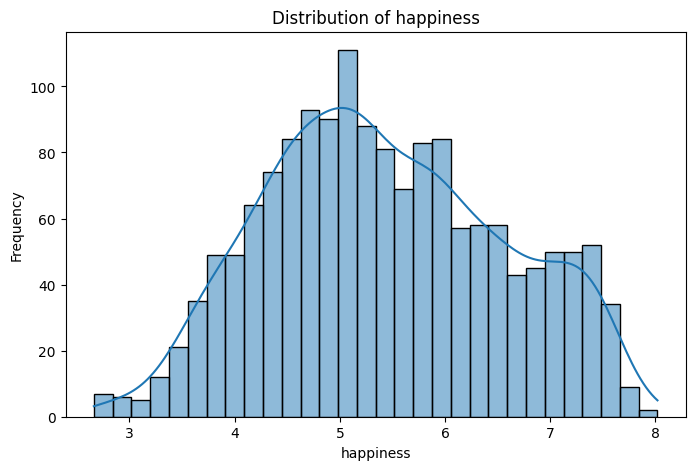

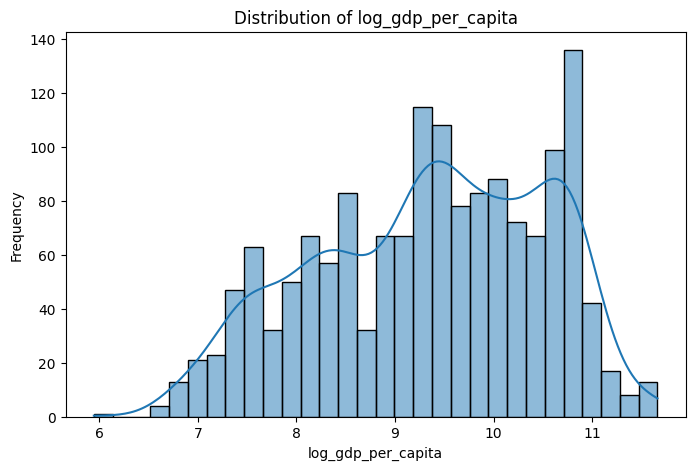

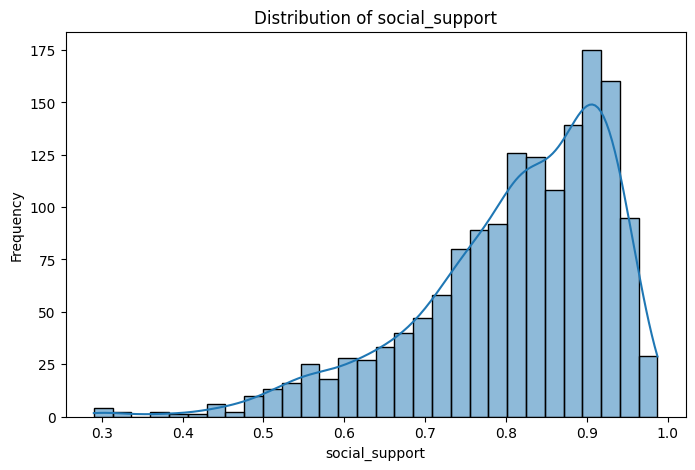

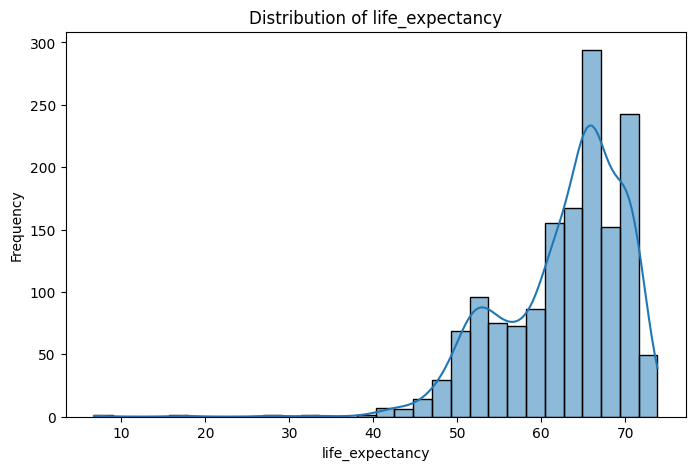

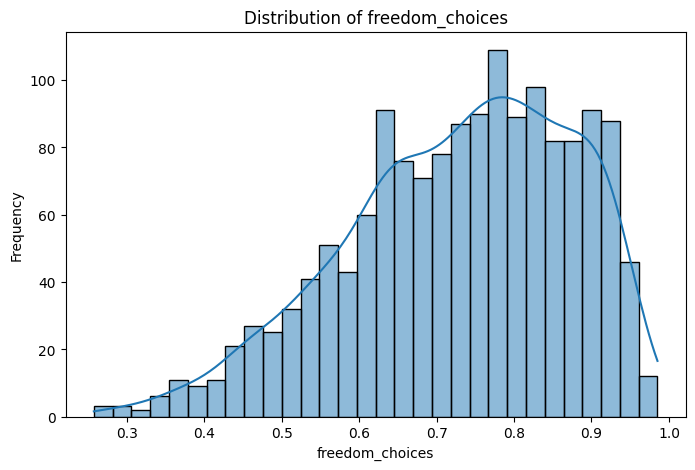

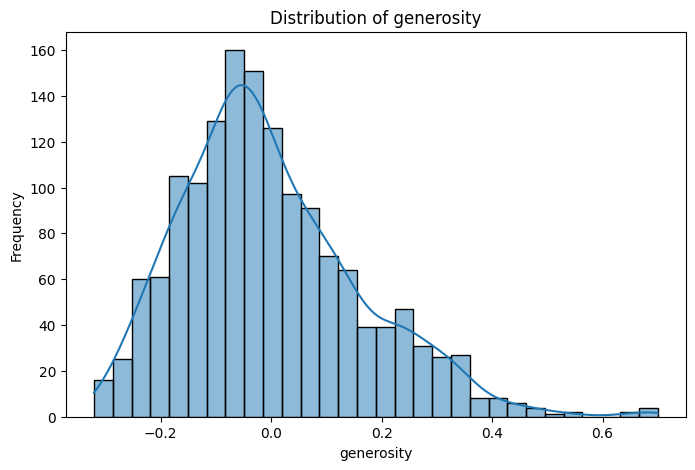

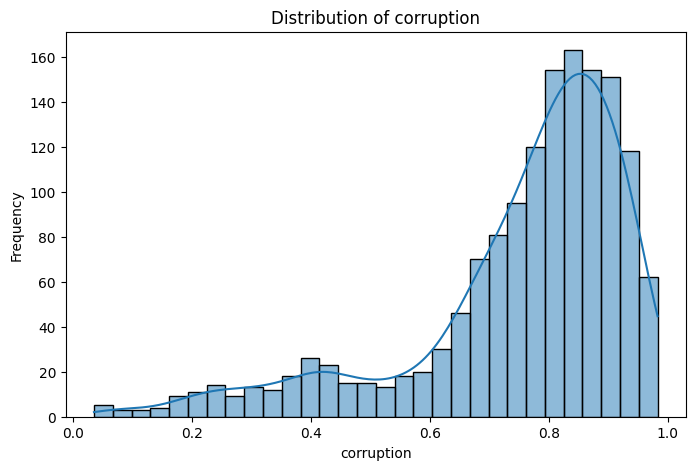

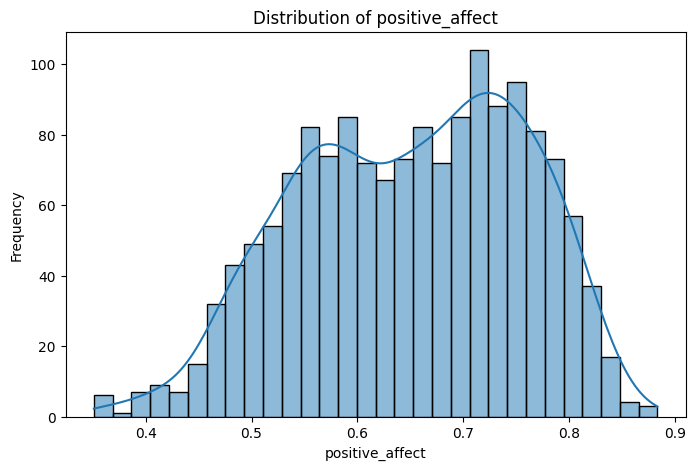

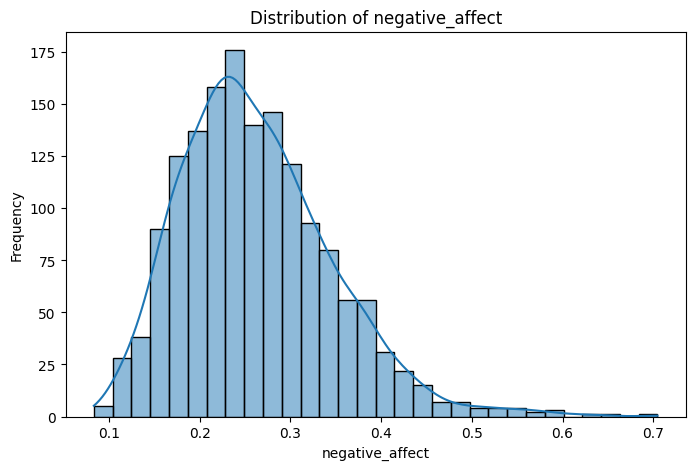

In [17]:
# Distributions of Numerical Features
numerical_features = ['happiness', 'log_gdp_per_capita', 'social_support', 'life_expectancy',
                      'freedom_choices', 'generosity', 'corruption', 'positive_affect', 'negative_affect']
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(train_data[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

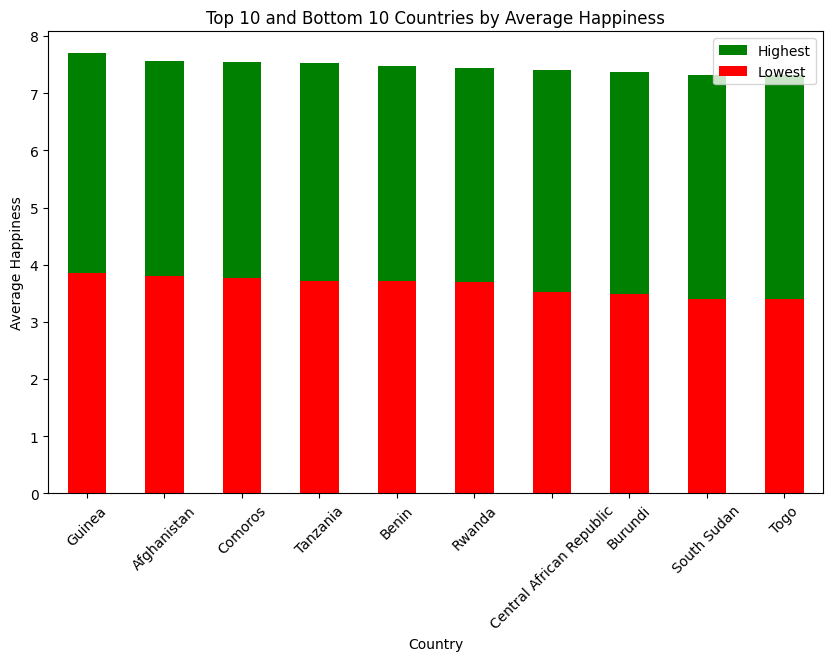

In [18]:
# Highest & Lowest Happiness Scores by Country
average_happiness = train_data.groupby("country")['happiness'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
average_happiness.head(10).plot(kind='bar', color='green', label='Highest')
average_happiness.tail(10).plot(kind='bar', color='red', label='Lowest')
plt.title("Top 10 and Bottom 10 Countries by Average Happiness")
plt.ylabel("Average Happiness")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.legend()
plt.show()

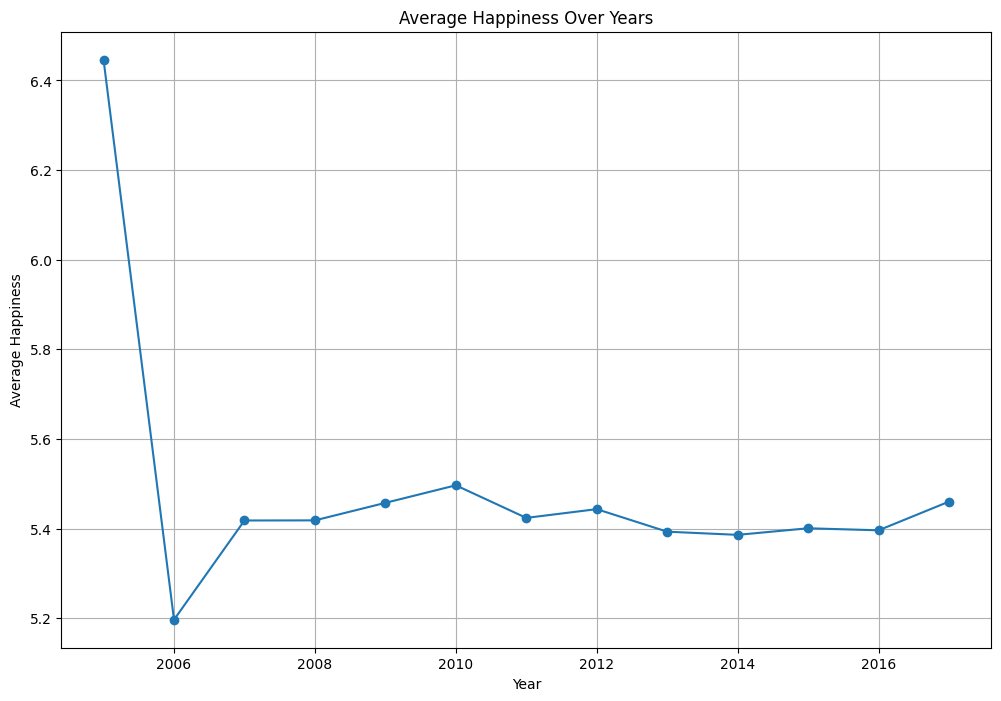

In [19]:
# Happiness Over the Years
plt.figure(figsize=(12, 8))
happiness_by_year = train_data.groupby("year")['happiness'].mean()
happiness_by_year.plot(marker='o')
plt.title("Average Happiness Over Years")
plt.ylabel("Average Happiness")
plt.xlabel("Year")
plt.grid(True)
plt.show()

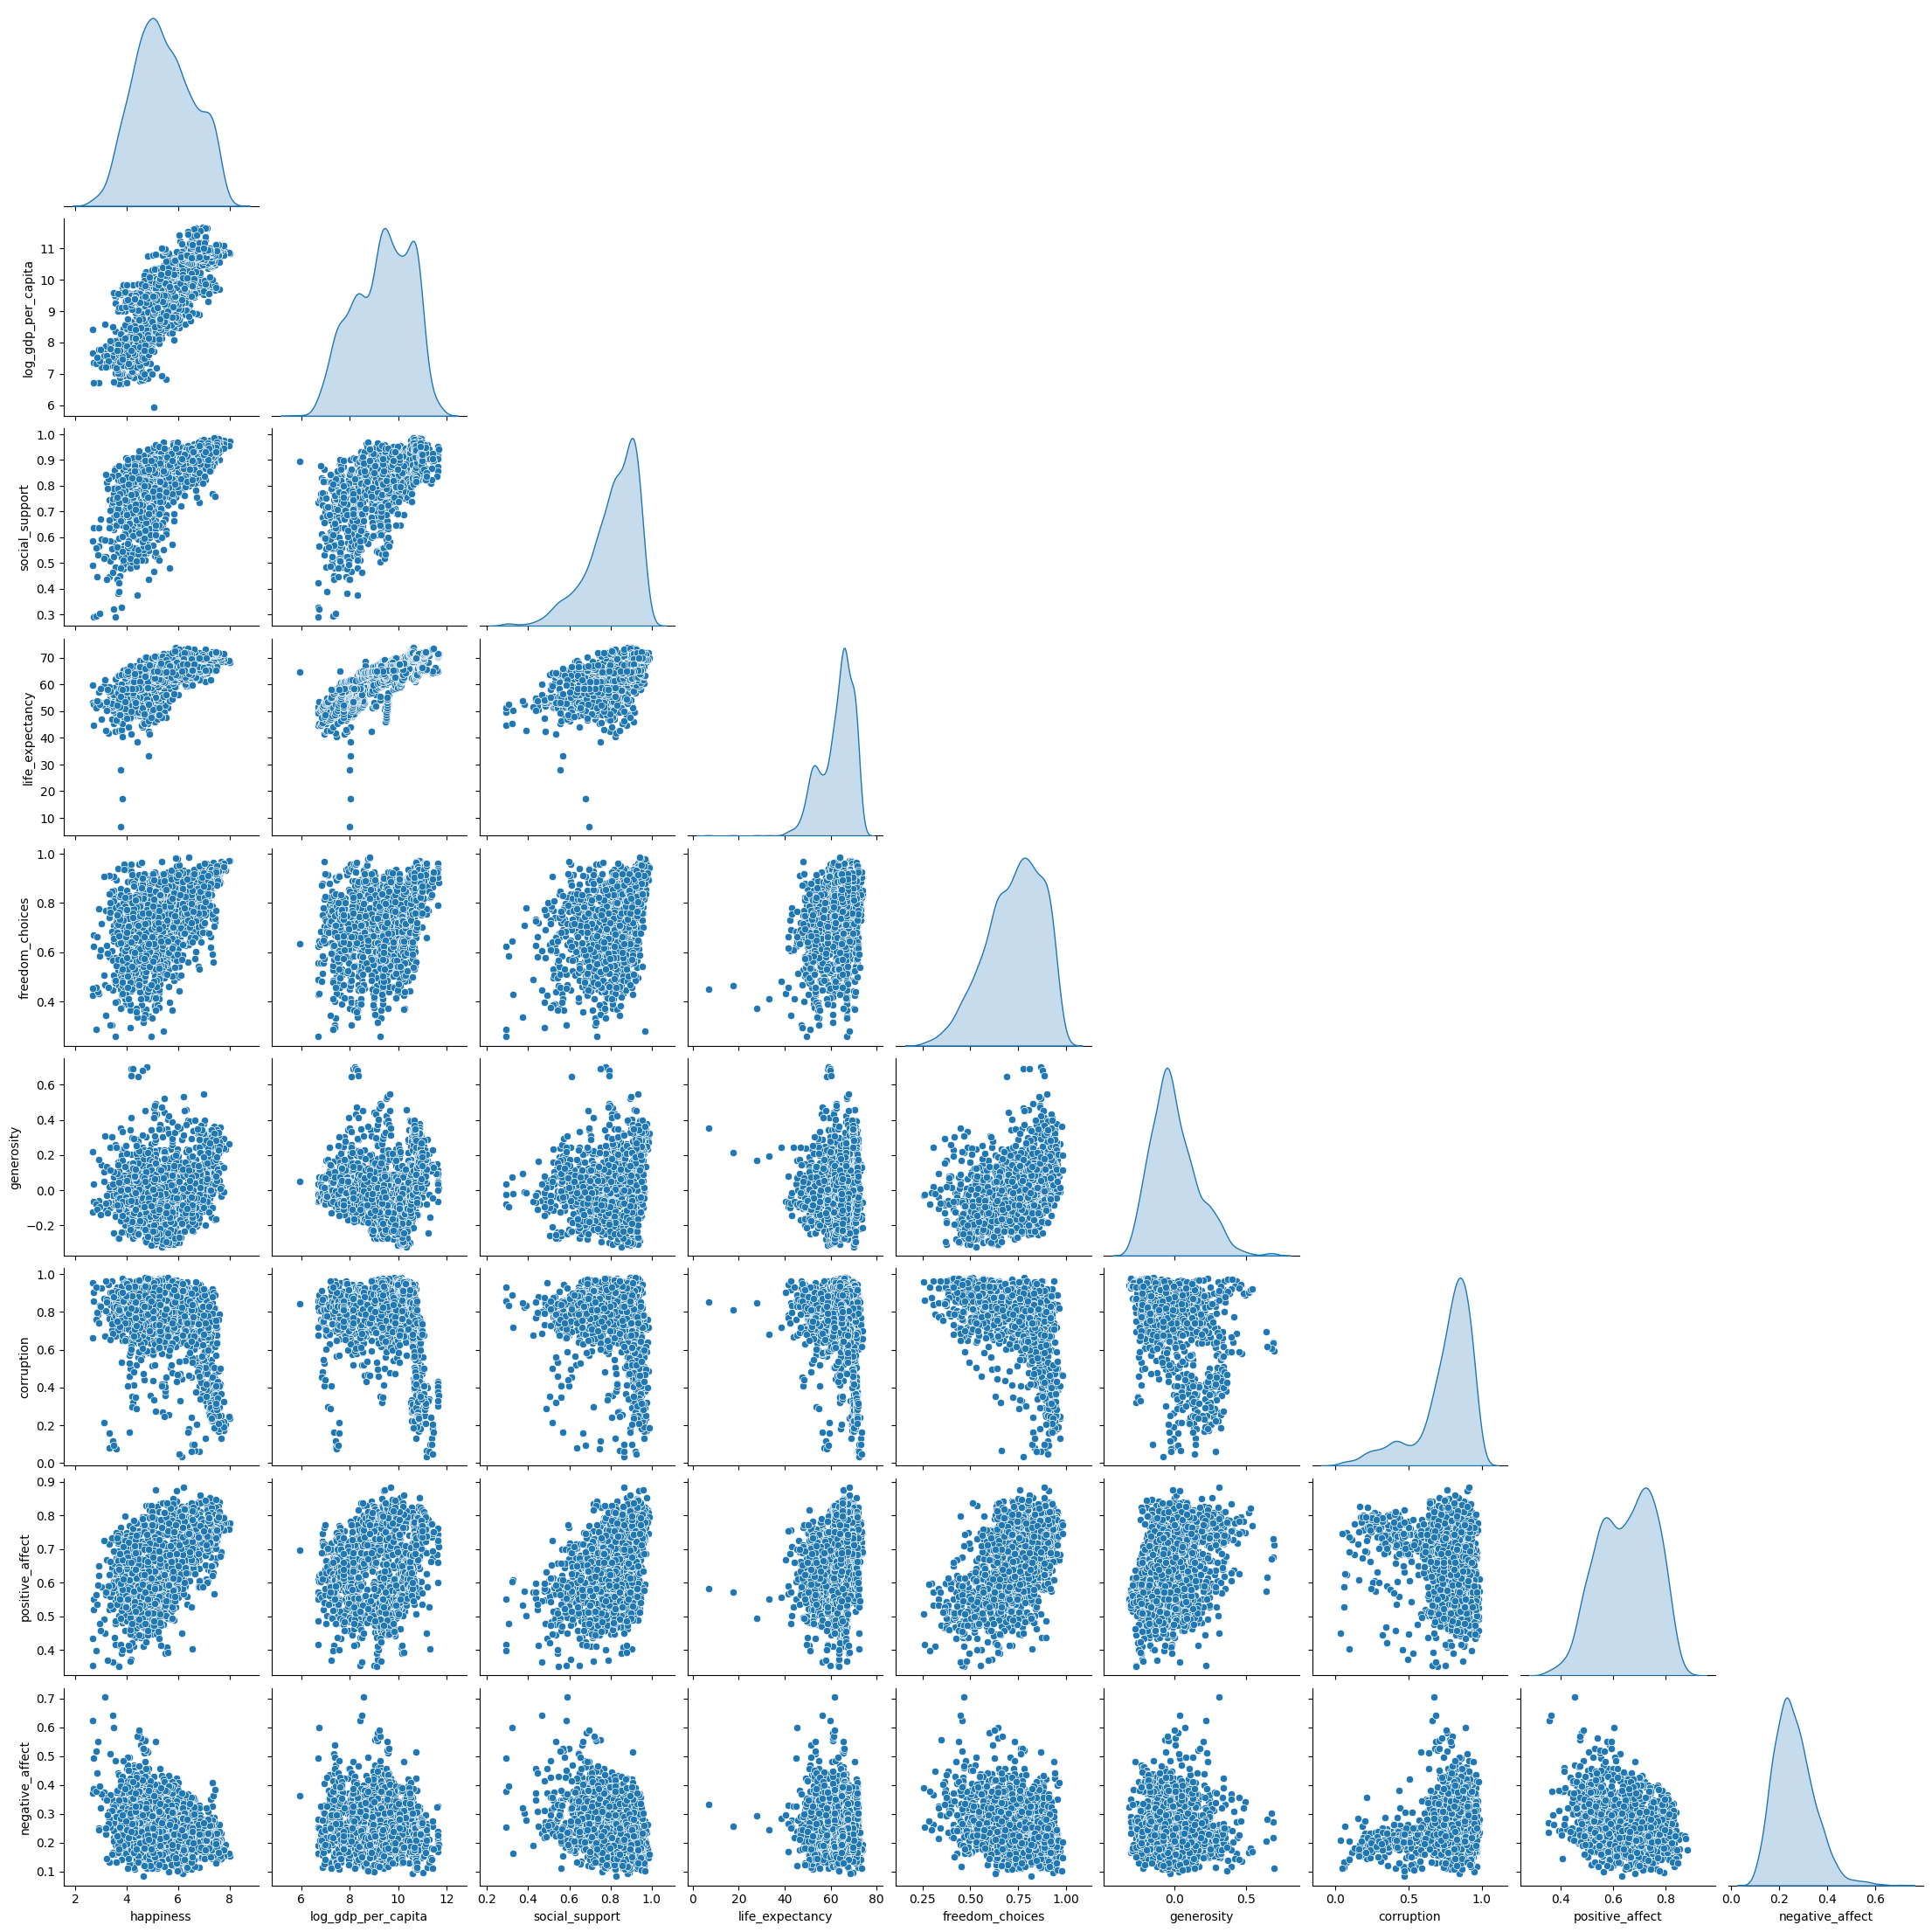

In [20]:
# Pair Plot
sns.pairplot(train_data[numerical_features], diag_kind='kde', corner=True)
plt.show()

In [21]:
print(train_data.columns)
# Happiness Score Change by Region
if 'region' in train_data.columns:
    grouped_year_region = train_data.groupby(by=['year', 'region'])['happiness'].median()
    unstacked_df = grouped_year_region.unstack()
    unstacked_df.plot(kind='line', marker='o', figsize=(15, 6))
    plt.xlabel('Year')
    plt.ylabel('Median Happiness Score')
    plt.title('Comparison of Median Happiness Scores by Region Over Years')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

Index(['country', 'year', 'happiness', 'log_gdp_per_capita', 'social_support',
       'life_expectancy', 'freedom_choices', 'generosity', 'corruption',
       'positive_affect', 'negative_affect', 'ID'],
      dtype='object')


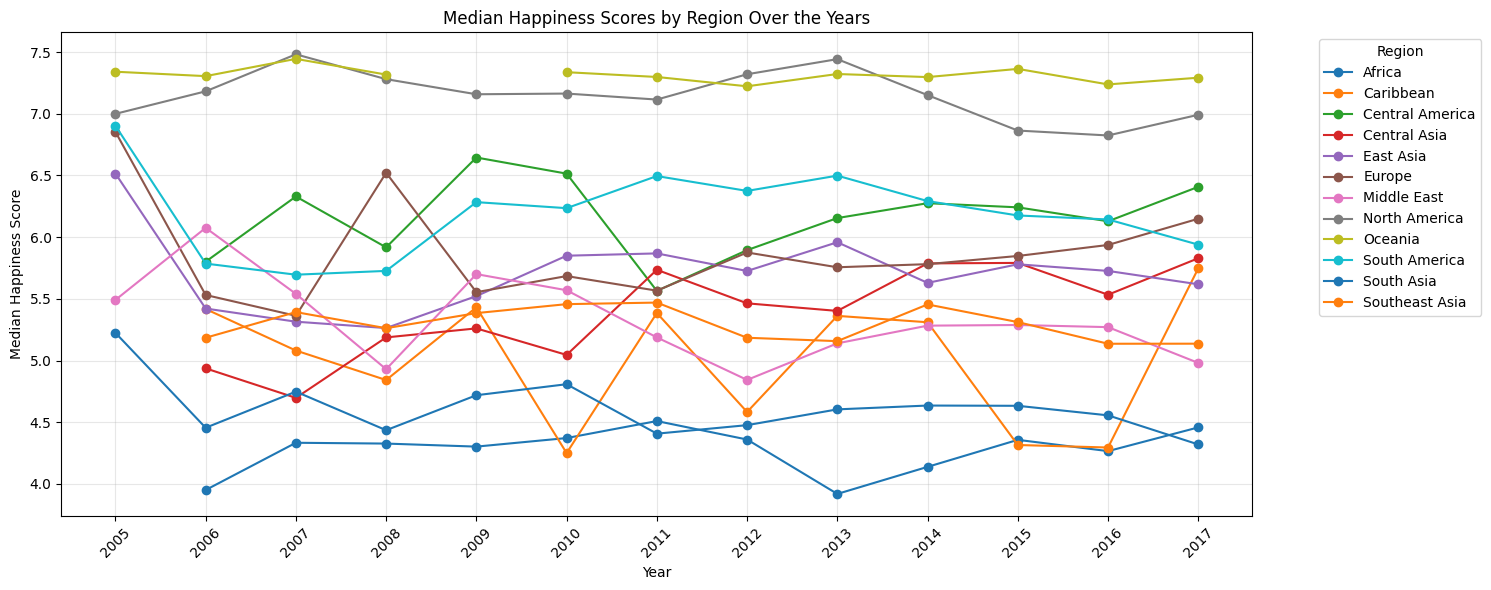

In [22]:
# Add Region Mapping
country_to_region = {
    'Afghanistan': 'South Asia',
    'Albania': 'Europe',
    'Algeria': 'Africa',
    'Angola': 'Africa',
    'Argentina': 'South America',
    'Armenia': 'Europe',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'Azerbaijan': 'Europe',
    'Bahrain': 'Middle East',
    'Bangladesh': 'South Asia',
    'Belarus': 'Europe',
    'Belgium': 'Europe',
    'Belize': 'Central America',
    'Benin': 'Africa',
    'Bhutan': 'South Asia',
    'Bolivia': 'South America',
    'Bosnia and Herzegovina': 'Europe',
    'Botswana': 'Africa',
    'Brazil': 'South America',
    'Bulgaria': 'Europe',
    'Burkina Faso': 'Africa',
    'Burundi': 'Africa',
    'Cambodia': 'Southeast Asia',
    'Cameroon': 'Africa',
    'Canada': 'North America',
    'Central African Republic': 'Africa',
    'Chad': 'Africa',
    'Chile': 'South America',
    'China': 'East Asia',
    'Colombia': 'South America',
    'Comoros': 'Africa',
    'Congo (Brazzaville)': 'Africa',
    'Congo (Kinshasa)': 'Africa',
    'Costa Rica': 'Central America',
    'Croatia': 'Europe',
    'Cuba': 'Caribbean',
    'Cyprus': 'Europe',
    'Czechia': 'Europe',
    'Denmark': 'Europe',
    'Djibouti': 'Africa',
    'Dominican Republic': 'Caribbean',
    'Ecuador': 'South America',
    'Egypt': 'Middle East',
    'El Salvador': 'Central America',
    'Estonia': 'Europe',
    'Eswatini': 'Africa',
    'Ethiopia': 'Africa',
    'Finland': 'Europe',
    'France': 'Europe',
    'Gabon': 'Africa',
    'Gambia': 'Africa',
    'Georgia': 'Europe',
    'Germany': 'Europe',
    'Ghana': 'Africa',
    'Greece': 'Europe',
    'Guatemala': 'Central America',
    'Guinea': 'Africa',
    'Guyana': 'South America',
    'Haiti': 'Caribbean',
    'Honduras': 'Central America',
    'Hong Kong S.A.R. of China': 'East Asia',
    'Hungary': 'Europe',
    'Iceland': 'Europe',
    'India': 'South Asia',
    'Indonesia': 'Southeast Asia',
    'Iran': 'Middle East',
    'Iraq': 'Middle East',
    'Ireland': 'Europe',
    'Israel': 'Middle East',
    'Italy': 'Europe',
    'Ivory Coast': 'Africa',
    'Jamaica': 'Caribbean',
    'Japan': 'East Asia',
    'Jordan': 'Middle East',
    'Kazakhstan': 'Central Asia',
    'Kenya': 'Africa',
    'Kosovo': 'Europe',
    'Kuwait': 'Middle East',
    'Kyrgyzstan': 'Central Asia',
    'Laos': 'Southeast Asia',
    'Latvia': 'Europe',
    'Lebanon': 'Middle East',
    'Lesotho': 'Africa',
    'Liberia': 'Africa',
    'Libya': 'Africa',
    'Lithuania': 'Europe',
    'Luxembourg': 'Europe',
    'Madagascar': 'Africa',
    'Malawi': 'Africa',
    'Malaysia': 'Southeast Asia',
    'Mali': 'Africa',
    'Malta': 'Europe',
    'Mauritania': 'Africa',
    'Mauritius': 'Africa',
    'Mexico': 'North America',
    'Moldova': 'Europe',
    'Mongolia': 'East Asia',
    'Montenegro': 'Europe',
    'Morocco': 'Africa',
    'Mozambique': 'Africa',
    'Myanmar': 'Southeast Asia',
    'Namibia': 'Africa',
    'Nepal': 'South Asia',
    'Netherlands': 'Europe',
    'New Zealand': 'Oceania',
    'Nicaragua': 'Central America',
    'Niger': 'Africa',
    'Nigeria': 'Africa',
    'North Macedonia': 'Europe',
    'Norway': 'Europe',
    'Oman': 'Middle East',
    'Pakistan': 'South Asia',
    'Panama': 'Central America',
    'Paraguay': 'South America',
    'Peru': 'South America',
    'Philippines': 'Southeast Asia',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Qatar': 'Middle East',
    'Romania': 'Europe',
    'Russia': 'Europe',
    'Rwanda': 'Africa',
    'Saudi Arabia': 'Middle East',
    'Senegal': 'Africa',
    'Serbia': 'Europe',
    'Sierra Leone': 'Africa',
    'Singapore': 'Southeast Asia',
    'Slovakia': 'Europe',
    'Slovenia': 'Europe',
    'Somalia': 'Africa',
    'Somaliland region': 'Africa',
    'South Africa': 'Africa',
    'South Korea': 'East Asia',
    'South Sudan': 'Africa',
    'Spain': 'Europe',
    'Sri Lanka': 'South Asia',
    'State of Palestine': 'Middle East',
    'Sudan': 'Africa',
    'Suriname': 'South America',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Syria': 'Middle East',
    'Taiwan Province of China': 'East Asia',
    'Tajikistan': 'Central Asia',
    'Tanzania': 'Africa',
    'Thailand': 'Southeast Asia',
    'Togo': 'Africa',
    'Trinidad and Tobago': 'Caribbean',
    'Tunisia': 'Africa',
    'Turkmenistan': 'Central Asia',
    'Türkiye': 'Europe',
    'Uganda': 'Africa',
    'Ukraine': 'Europe',
    'United Arab Emirates': 'Middle East',
    'United Kingdom': 'Europe',
    'United States': 'North America',
    'Uruguay': 'South America',
    'Uzbekistan': 'Central Asia',
    'Venezuela': 'South America',
    'Vietnam': 'Southeast Asia',
    'Yemen': 'Middle East',
    'Zambia': 'Africa',
    'Zimbabwe': 'Africa'
}

train_data['region'] = train_data['country'].map(country_to_region)

# Check for unmapped countries
unmapped_countries = train_data[train_data['region'].isna()]['country'].unique()
if len(unmapped_countries) > 0:
    print("Unmapped countries:", unmapped_countries)

# Happiness Score Change by Region
if 'region' in train_data.columns:
    grouped_year_region = train_data.groupby(by=['year', 'region'])['happiness'].median()
    unstacked_df = grouped_year_region.unstack()  # Pivot table for easier plotting
    plt.figure(figsize=(15, 6))
    for region in unstacked_df.columns:
        plt.plot(unstacked_df.index, unstacked_df[region], marker='o', label=region)
    plt.xlabel('Year')
    plt.ylabel('Median Happiness Score')
    plt.title('Median Happiness Scores by Region Over the Years')
    plt.xticks(unstacked_df.index, rotation=45)
    plt.grid(alpha=0.3)
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [45]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = train_data['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Blues',
            text = train_data['country'],
            z = train_data['happiness'],
            colorbar = {'title':'happiness score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
happiness_map = gobj.Figure(data=[data])#,layout=layout)

happiness_map.update_layout(title_text = 'Happiness Score by Country')

#plotting the map
iplot(happiness_map)



In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Drop unnecessary columns
X = train_data.drop(columns=["happiness", "ID", "country"])
y = train_data["happiness"]

# Handle categorical data using One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Train the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)


RandomForestRegressor(random_state=42)

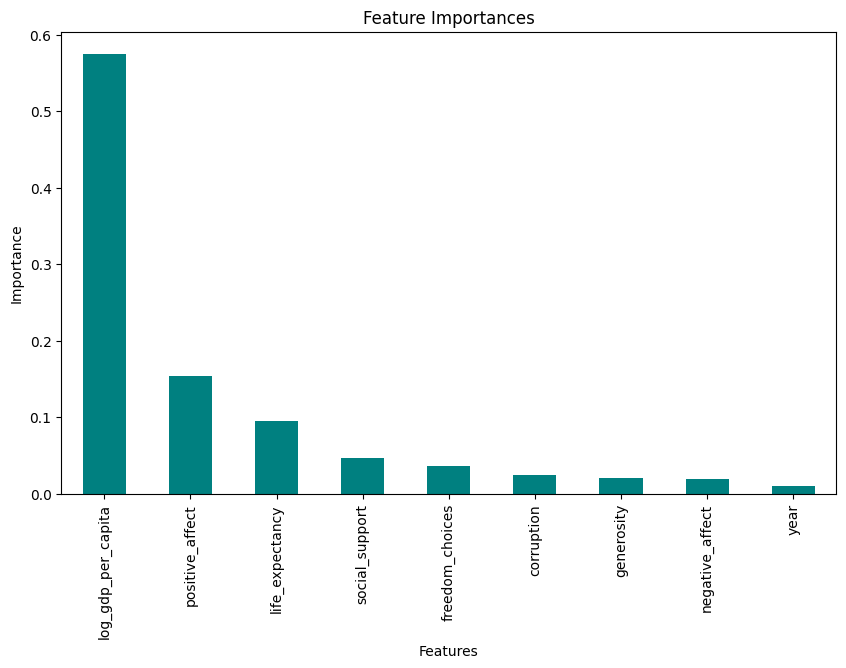

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'rf' is your RandomForest model and 'X' is your DataFrame
# Calculate feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Select the first (total number of features - 11) features
top_features = feature_importances.iloc[:-11]

# Plot the selected feature importances
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='teal')
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

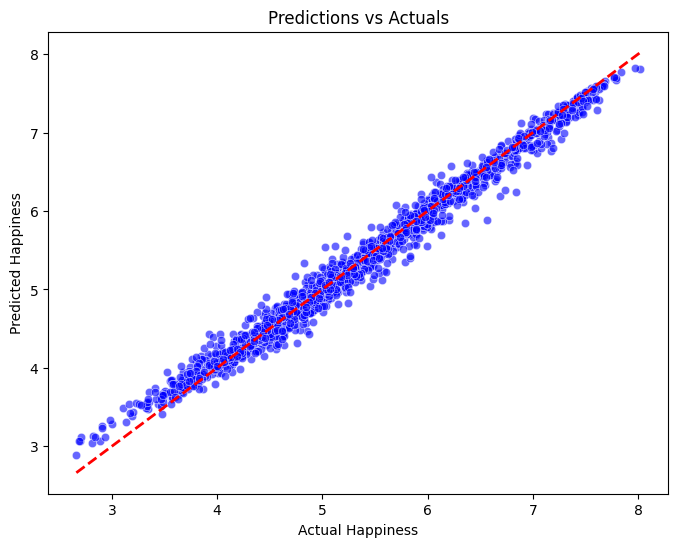

In [38]:
# Predictions vs Actuals (Assuming y_pred is already calculated)
y_pred = rf.predict(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', color='red', linewidth=2)
plt.title("Predictions vs Actuals")
plt.xlabel("Actual Happiness")
plt.ylabel("Predicted Happiness")
plt.show()

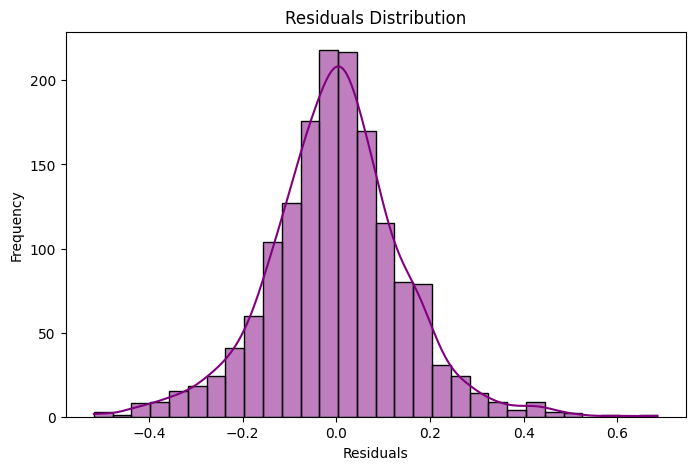

In [39]:
# Residual Analysis
residuals = y - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



<Figure size 1000x700 with 0 Axes>

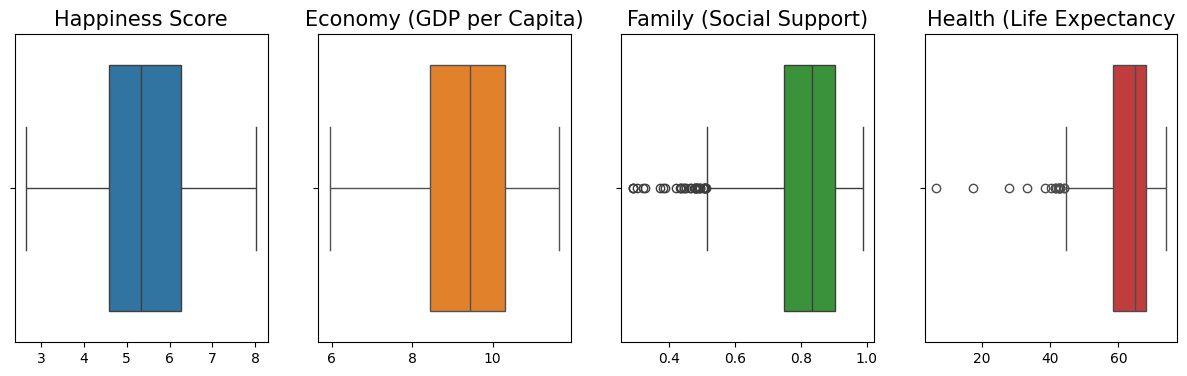

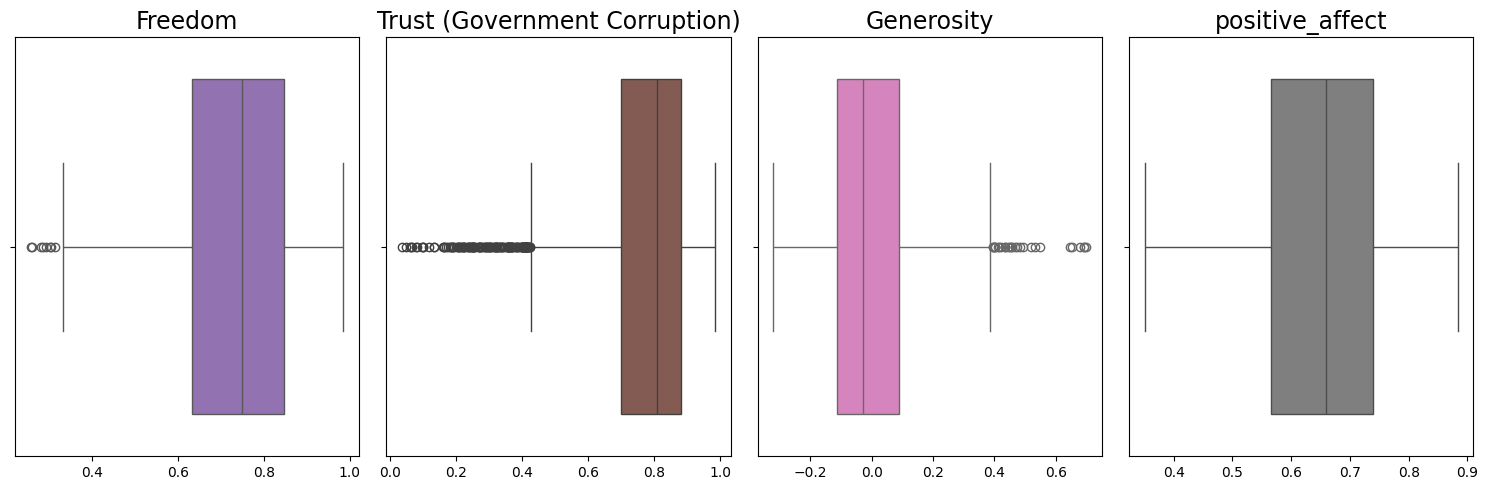

In [51]:
fig = plt.figure(figsize=(10,7));
(topfig,bottomfig) = fig.subfigures(2,1);

# Index(['country', 'year', 'happiness', 'log_gdp_per_capita', 'social_support','life_expectancy', 'freedom_choices', 'generosity', 'corruption','positive_affect', 'negative_affect', 'ID'],

topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,4,figsize=(15,4));
axes[0] = sns.boxplot(x=train_data['happiness'],ax=axes[0],color='#1f77b4')
axes[0].set_title('Happiness Score',fontsize=15);
axes[0].set_xlabel('',fontsize=1);
axes[1] = sns.boxplot(x=train_data['log_gdp_per_capita'],ax=axes[1],color='#ff7f0e')
axes[1].set_title('Economy (GDP per Capita)',fontsize=15);
axes[1].set_xlabel('',fontsize=1);
axes[2] = sns.boxplot(x=train_data['social_support'],ax=axes[2],color='#2ca02c')
axes[2].set_title('Family (Social Support)',fontsize=15);
axes[2].set_xlabel('',fontsize=1);
axes[3] = sns.boxplot(x=train_data['life_expectancy'],ax=axes[3],color='#d62728')
axes[3].set_title('Health (Life Expectancy',fontsize=15);
axes[3].set_xlabel('',fontsize=1);

bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,4,figsize=(15,5));
axes[0] = sns.boxplot(x=train_data['freedom_choices'],ax=axes[0],color='#9467bd')
axes[0].set_title('Freedom',fontsize=17);
axes[0].set_xlabel('',fontsize=1);
axes[1] = sns.boxplot(x=train_data['corruption'],ax=axes[1],color='#8c564b')
axes[1].set_title('Trust (Government Corruption)',fontsize=17);
axes[1].set_xlabel('',fontsize=1);
axes[2] = sns.boxplot(x=train_data['generosity'],ax=axes[2],color='#e377c2')
axes[2].set_title('Generosity',fontsize=17);
axes[2].set_xlabel('',fontsize=1);
axes[3] = sns.boxplot(x=train_data['positive_affect'],ax=axes[3],color='#7f7f7f')
axes[3].set_title('positive_affect',fontsize=17);
axes[3].set_xlabel('',fontsize=1);

plt.tight_layout()

1. Linear Regression Coefficients and Significance




In [30]:
import statsmodels.api as sm

numerical_features = X.select_dtypes(include=["float64", "int64"]).columns.drop("year")

# Define numerical features (ensure this matches your dataset)
numerical_features = [
    "log_gdp_per_capita",
    "social_support",
    "life_expectancy",
    "freedom_choices",
    "generosity",
    "corruption",
    "positive_affect",
    "negative_affect",
]


# Prepare data from train_data
X_numerical = train_data[numerical_features]  # Use the redefined numerical_features
X_with_const = sm.add_constant(X_numerical)  # Adding a constant term
y = train_data['happiness']

# # Check for missing or infinite values in numerical features
# print("Checking for NaNs or infinities...")
# print(X_numerical.isnull().sum())  # Check for missing values
# print(np.isinf(X_numerical).sum())  # Check for infinite values

# Handle missing and infinite values
X_numerical_cleaned = X_numerical.copy()
X_numerical_cleaned = X_numerical_cleaned.fillna(X_numerical.mean())  # Impute NaNs with mean
X_numerical_cleaned = X_numerical_cleaned.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
X_numerical_cleaned = X_numerical_cleaned.dropna()  # Drop any remaining NaNs

# Ensure the target variable aligns with the cleaned features
y_cleaned = y.loc[X_numerical_cleaned.index]

# Add a constant term for the regression
X_with_const = sm.add_constant(X_numerical_cleaned)

# Fit the model
model = sm.OLS(y_cleaned, X_with_const).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              happiness   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     654.5
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:25:55   Log-Likelihood:                -1248.3
No. Observations:                1563   AIC:                             2515.
Df Residuals:                    1554   BIC:                             2563.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.7735      0

2. Feature Importance (Random Forest)

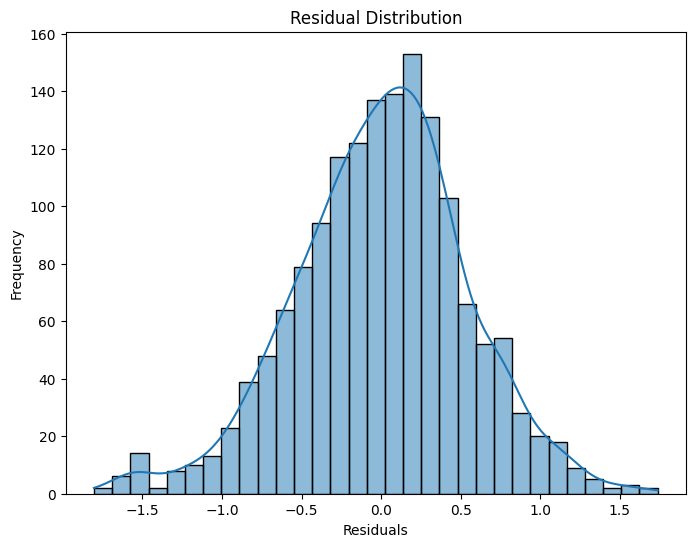

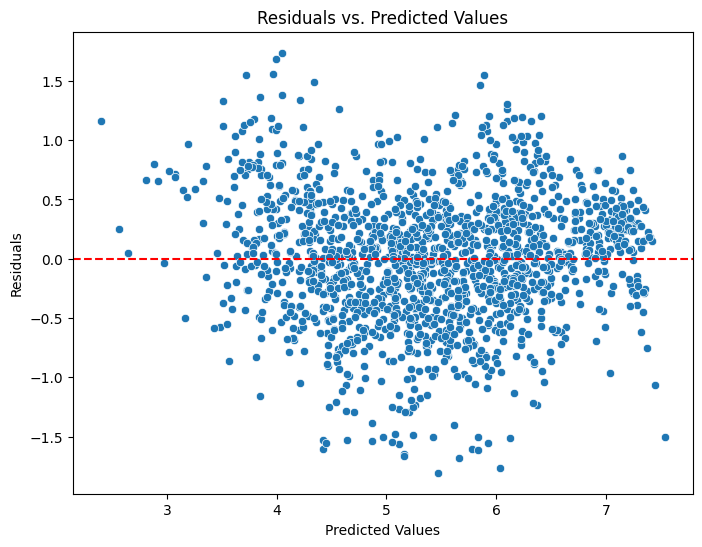

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y - model.predict(X_with_const)

# Residual Plot
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Residual vs. Predicted Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=model.predict(X_with_const), y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_numerical = X_numerical.fillna(X_numerical.mean())

# Calculate VIF for numerical features
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numerical.columns
vif_data['VIF'] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
              Feature         VIF
0  log_gdp_per_capita  226.126572
1      social_support  111.132302
2     life_expectancy  222.800189
3     freedom_choices   49.865904
4          generosity    1.247628
5          corruption   18.989081
6     positive_affect   63.764004
7     negative_affect   12.779379
